In [35]:
'''
This note is about some traditional pde algorithm i want to implement.
1.Finite difference
2.Finite volume
3.Finite element
About the pde,the laplace equation used for example.
    Lap u = -f, in Domain
    u = g = 1 on partial domain
    
    f = 2(2pi)**2sin(2pix)sin(2piy)
    u = sin(spix)sin(spiy) + 1
'''
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import torch
from scipy import sparse
from scipy.sparse.linalg import spsolve
from random import sample
# 1.We first declare a zero matrix perpareing for generate the stiff matrix
f = lambda x,y: 8*np.pi**2*np.sin(2*np.pi*x)*np.sin(2*np.pi*y) 
u = lambda x,y: np.sin(2*np.pi*x)*np.sin(2*np.pi*y) 

def mean_L2(pre, ans, h):
    pre = pre.flatten()
    ans = ans.flatten()
    diff = (pre - ans)**2 * h**2
    diff = np.sqrt(diff.sum())
    return diff

def np2torch(A):
    values = A.data
    indices = np.vstack((A.row, A.col))
    
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = A.shape
    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to(torch.float32)

In [39]:
def finite_diff_solver_2rd(f, dx, dy, left, right, bottom, top):
    Nx = round((right - left)/dx) + 1
    Ny = round((top - bottom)/dy) + 1
    N = Nx * Ny
    A = sparse.lil_matrix((N, N))
    b = np.zeros(N)
    
    for i in range(Nx):
        for j in range(Ny):
            idx = i * Ny + j
            if i == 0 or j == 0 or i==(Nx-1) or j==(Ny-1):
                A[idx, idx] = 1
                b[idx] = 0
            else:
                A[idx, idx] += (2/dx**2 + 2/dy**2)
                A[idx, idx-1] = -1/dy**2
                A[idx, idx+1] = -1/dy**2
                A[idx, (i-1)*Ny + j] = -1/dx**2
                A[idx, (i+1)*Ny + j] = -1/dx**2            

#                 x = left + j * dx
#                 y = bottom + i * dy
                b[idx] = f[i, j]
    A = A.tocsr()
    pre = spsolve(A, b)
    return pre

def finite_diff_solver_4rd(f, h, left, right, bottom, top):
    Nx = round((right - left)/h) + 1
    Ny = round((top - bottom)/h) + 1
    N = Nx * Ny
    A = sparse.lil_matrix((N, N))
    b = np.zeros(N)
    h2 = h**2
    
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            idx = i * Ny + j
            
            A[idx, idx] = 20/h2
            A[idx, idx-1] = -4/h2
            A[idx, idx+1] = -4/h2
            A[idx, (i-1)*Ny + j] = -4/h2
            A[idx, (i+1)*Ny + j] = -4/h2
            
            A[idx, (i-1)*Ny+j-1] = -1/h2
            A[idx, (i-1)*Ny+j+1] = -1/h2
            A[idx, (i+1)*Ny+j-1] = -1/h2
            A[idx, (i+1)*Ny+j+1] = -1/h2
            
            b[idx] += (8*f[i,j] + f[i-1,j] + f[i+1,j] + f[i,j-1] + f[i, j+1])/2
            
    #     boundary
    for j in range(0, Ny):
        idx = 0 * Ny + j
        A[idx, idx] = 1
        b[idx] = 0
        
        idx = (Nx-1) * Ny + j
        A[idx, idx] = 1
        b[idx] = 0
        
    for i in range(0, Nx):
        idx = i * Nx
        A[idx, idx] = 1
        b[idx] = 0
        
        idx = i * Nx + Ny - 1 
        A[idx, idx] = 1
        b[idx] = 0
        
    A = A.tocsr()
#     print(A.todense())
    pre = spsolve(A, b)
    return pre

left = 0
bottom = 0
top = 1
right = 1
h = 1/256
Nx = round((right - left)/h) + 1
Ny = round((top - bottom)/h) + 1
x = np.linspace(left, right, Nx)
y = np.linspace(bottom, top, Ny)
xx, yy = np.meshgrid(x, y)
f_mat = f(xx, yy)
real = u(xx, yy)
ans = finite_diff_solver_2rd(f_mat, h, h, left, right, bottom, top)
print(np.linalg.norm(ans-real.flatten()))

0.006425717227114901


In [40]:
def compute_order(f, u, left, right, bottom, top, hs):
    
    errors_2nd = []
    errors_4th = []
    for h in hs:
        Nx = round((right - left)/h) + 1
        Ny = round((top - bottom)/h) + 1
        x = np.linspace(left, right, Nx)
        y = np.linspace(bottom, top, Ny)
        xx, yy = np.meshgrid(x, y)
        force = f(xx, yy)
        ue = u(xx, yy).flatten()
        
        ua_2nd = finite_diff_solver_2rd(force, h, h, left, right, bottom, top)
        ua_4th = finite_diff_solver_4rd(force, h, left, right, bottom, top)
        
#         error_2nd = np.linalg.norm(ua_2nd-ue)
#         error_4th = np.linalg.norm(ua_4th-ue)
        error_2nd = mean_L2(ua_2nd, ue, h)
        error_4th = mean_L2(ua_4th, ue, h)
    
        errors_2nd.append(error_2nd)
        errors_4th.append(error_4th)
    
    print(f"{'mesh size':>11s} {'error_2nd':>11s} {'ratio_2nd':>11s} {'error_4th':>11s} {'ratio_4th':>11s}")
    for i, h in enumerate(hs):
        if i == 0:
            print(f"{h:>11.4e} {errors_2nd[i]:>11.3e} {' ':>11s} {errors_4th[i]:>11.3e}")
        else:
            ratio_2nd = np.log(errors_2nd[i-1]/errors_2nd[i])/np.log(hs[i-1]/hs[i])
            ratio_4th = np.log(errors_4th[i-1]/errors_4th[i])/np.log(hs[i-1]/hs[i])
#             ratio_4th = np.log(errors_4th[i-1]/errors_4th[i])
            
            print(f"{h:>11.4e} {errors_2nd[i]:>11.3e} {ratio_2nd:>11.3f} {errors_4th[i]:>11.3e} {ratio_4th:>11.3f}")
    
compute_order(f, u, 0, 1, 0, 1, [0.5, 0.2, 0.1, 0.05, 0.025, 0.0125])

  mesh size   error_2nd   ratio_2nd   error_4th   ratio_4th
 5.0000e-01   4.712e-32               3.746e-32
 2.0000e-01   7.134e-02     -75.841   3.024e-03     -72.642
 1.0000e-01   1.678e-02       2.088   2.109e-04       3.842
 5.0000e-02   4.133e-03       2.022   1.345e-05       3.971
 2.5000e-02   1.029e-03       2.005   8.443e-07       3.993
 1.2500e-02   2.571e-04       2.001   5.283e-08       3.998


In [45]:
f = lambda x,y: 8*np.pi**2*np.sin(2*np.pi*x)*np.sin(2*np.pi*y) 
u = lambda x,y: np.sin(2*np.pi*x)*np.sin(2*np.pi*y) 

def assmble_2nd(a, n, f, g, u, name_A, name_b, name_U, name_F, Qs):
#     n = round(a/h) + 1
    h = a/(n-1)
    h2 = h**2
    x = np.linspace(0, a, n)
    y = np.linspace(0, a, n)
    xx, yy = np.meshgrid(x, y)
    f = f(xx, yy)
    u = u(xx, yy).flatten()
    N = n**2
    A = sparse.lil_matrix((N, N))
    
    data_nums = len(Qs)
    b = np.zeros((data_nums, N))
    F = np.zeros((data_nums, N))
    U = np.zeros((data_nums, N))
    for k, Q in enumerate(Qs):
        U[k,:] = Q * u    
        F[k, :] = Q * f.flatten()
    np.save(name_U, U)
    np.save(name_F, F)
    
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            if i==0 or j==0 or i==(n-1) or j==(n-1):
                A[idx, idx] = 1
                for k in range(data_nums):
                    b[k, idx] = g
            else:
                A[idx, idx] = -4/h2
                A[idx, idx-1] = 1/h2
                A[idx, idx+1] = 1/h2
                A[idx, (i-1)*n + j] = 1/h2
                A[idx, (i+1)*n + j] = 1/h2            
                
                for k, Q in enumerate(Qs):
                    force = Q * f
                    b[k, idx] = -force[i, j]
                    
    A = A.tocoo()    
    sparse.save_npz(name_A, A)
    np.save(name_b, b)
    return True
    
def assmble_4th(a, n, f, g, u, name_A, name_b, name_U, name_F, Qs):
#     n = round(a/h) + 1
    h = a/(n-1)
    x = np.linspace(0, a, n)
    y = np.linspace(0, a, n)
    xx, yy = np.meshgrid(x, y)
    f = f(xx, yy)
    u = u(xx, yy).flatten()
    
    N = n**2
    h2 = h**2
    A = sparse.lil_matrix((N, N))
    
    data_nums = len(Qs)
    b = np.zeros((data_nums, N))
    F = np.zeros((data_nums, N))
    U = np.zeros((data_nums, N))
    for k, Q in enumerate(Qs):
        U[k,:] = Q * u    
        F[k,:] = Q * f.flatten()    
    np.save(name_U, U)
    np.save(name_F, F)
    
    for i in range(1, n-1):
        for j in range(1, n-1):
            idx = i * n + j
            
            A[idx, idx] = 20/h2
            A[idx, idx-1] = -4/h2
            A[idx, idx+1] = -4/h2
            A[idx, (i-1)*n + j] = -4/h2
            A[idx, (i+1)*n + j] = -4/h2
            
            A[idx, (i-1)*n+j-1] = -1/h2
            A[idx, (i-1)*n+j+1] = -1/h2
            A[idx, (i+1)*n+j-1] = -1/h2
            A[idx, (i+1)*n+j+1] = -1/h2
            
            for k, Q in enumerate(Qs):
                force = Q * f
                b[k, idx] = (8*force[i,j] + force[i-1,j] + force[i+1,j] + force[i,j-1] + force[i, j+1])/2
            
    #     boundary
    for j in range(0, n):
        idx = 0 * n + j
        A[idx, idx] = 1
        for k in range(data_nums):
            b[k, idx] = g
        
        idx = (n-1) * n + j
        A[idx, idx] = 1
        for k in range(data_nums):
            b[k, idx] = g
        
    for i in range(0, n):
        idx = i * n
        A[idx, idx] = 1
        for k in range(data_nums):
            b[k, idx] = g
        
        idx = i * n + n - 1 
        A[idx, idx] = 1
        for k in range(data_nums):
            b[k, idx] = g
        
    A = A.tocoo()    
    sparse.save_npz(name_A, A)
    np.save(name_b, b)
    return True

# Qs = sample(list(np.linspace(1, 1.5, 10)), 10)
# # h=0.01
# assmble_4th(a=1, n=128, f=f, g=0, u=u,name_A='ValA4th.npz', name_b='ValB4th.npy', name_U='ValU4th.npy', name_F='ValF4th.npy',Qs=Qs)
# assmble_2nd(a=1, n=128, f=f, g=0, u=u,name_A='ValA2nd.npz', name_b='ValB2nd.npy', name_U='ValU2nd.npy', name_F='ValF2nd.npy',Qs=Qs)

# Qs = sample(list(np.linspace(1, 1.5, 2000)), 2000)
# # h=0.01
# assmble_4th(a=1, n=128, f=f, g=0, u=u,name_A='A4th.npz', name_b='B4th.npy', name_U='U4th.npy', name_F='F4th.npy', Qs=Qs)
# assmble_2nd(a=1, n=128, f=f, g=0, u=u,name_A='A2nd.npz', name_b='B2nd.npy', name_U='U2nd.npy', name_F='F2nd.npy',Qs=Qs)



True

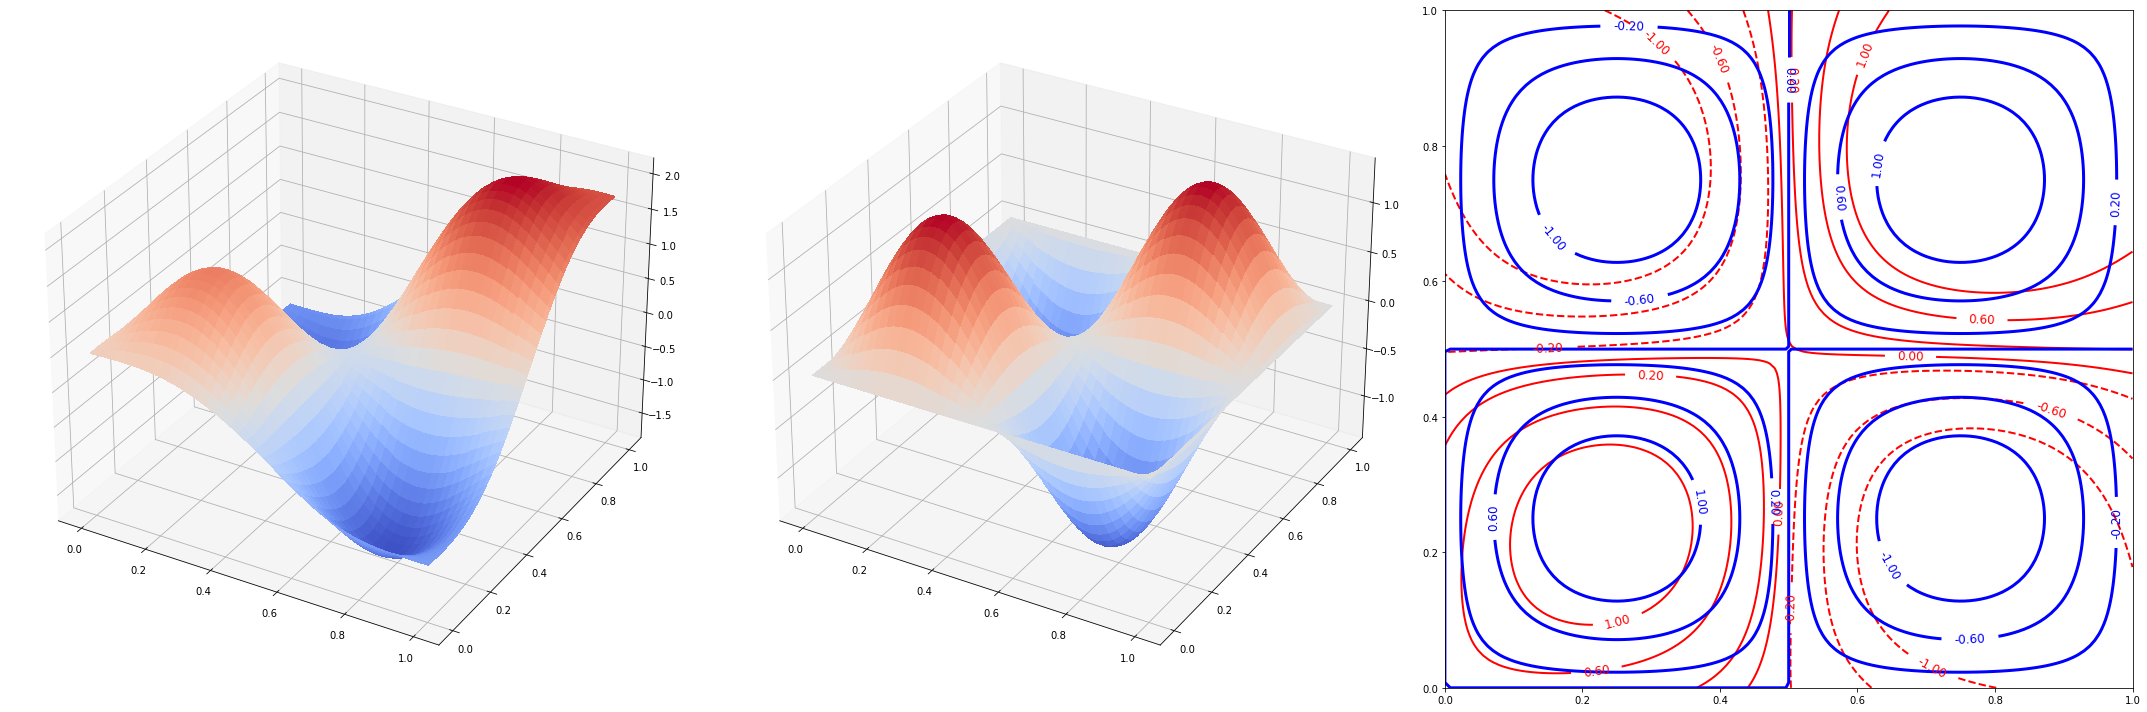

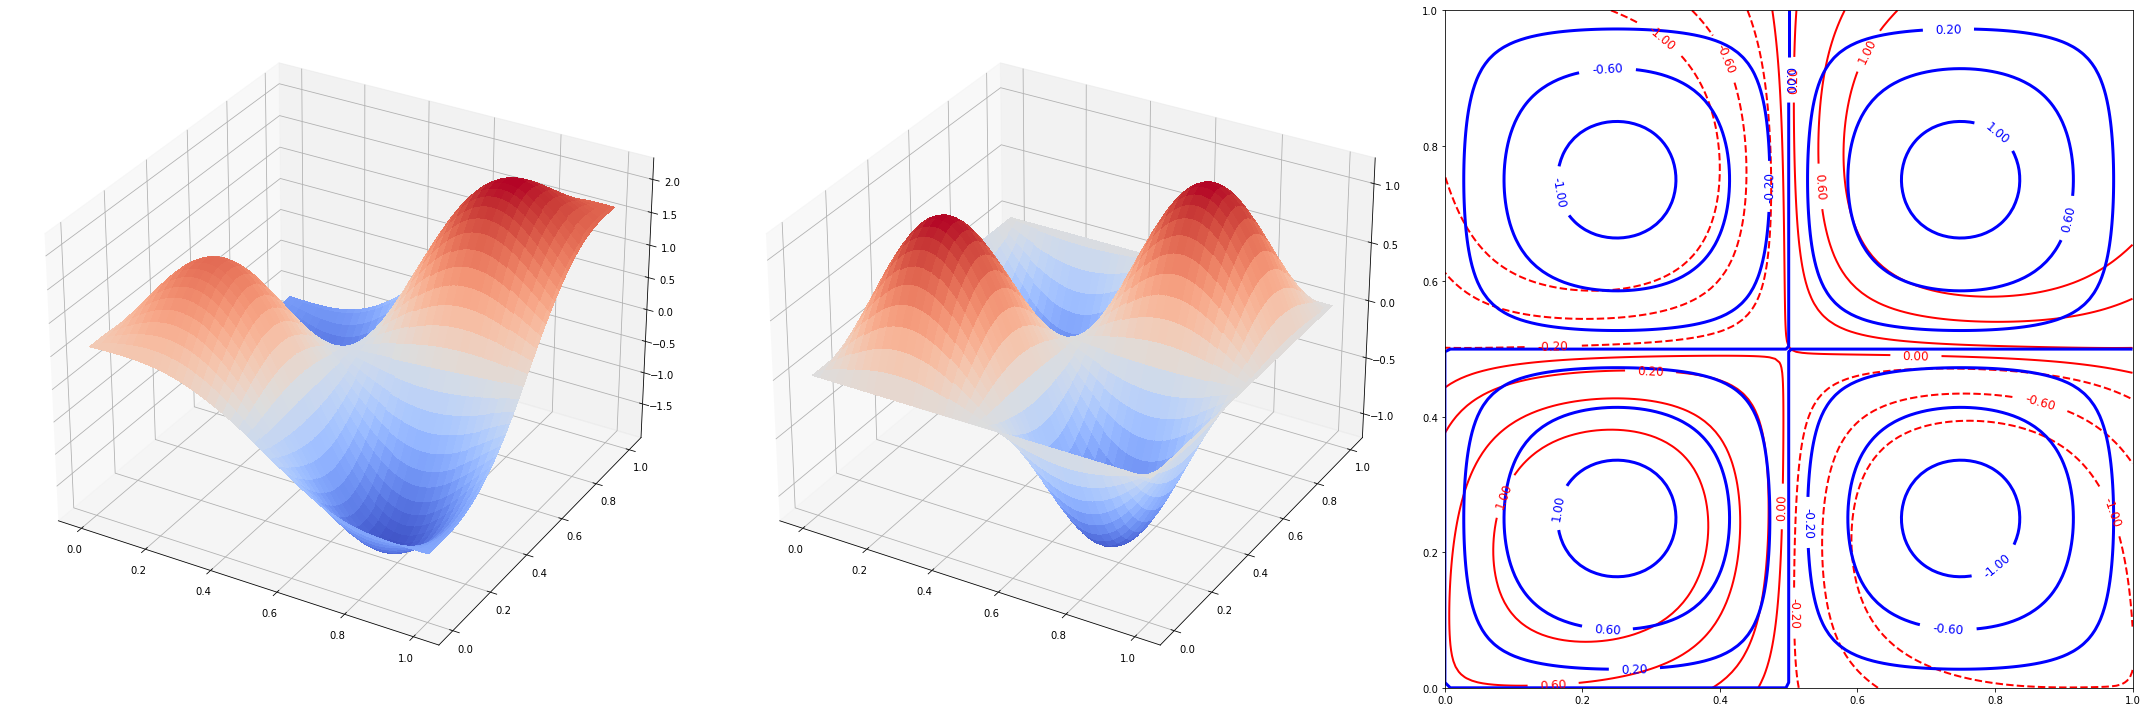

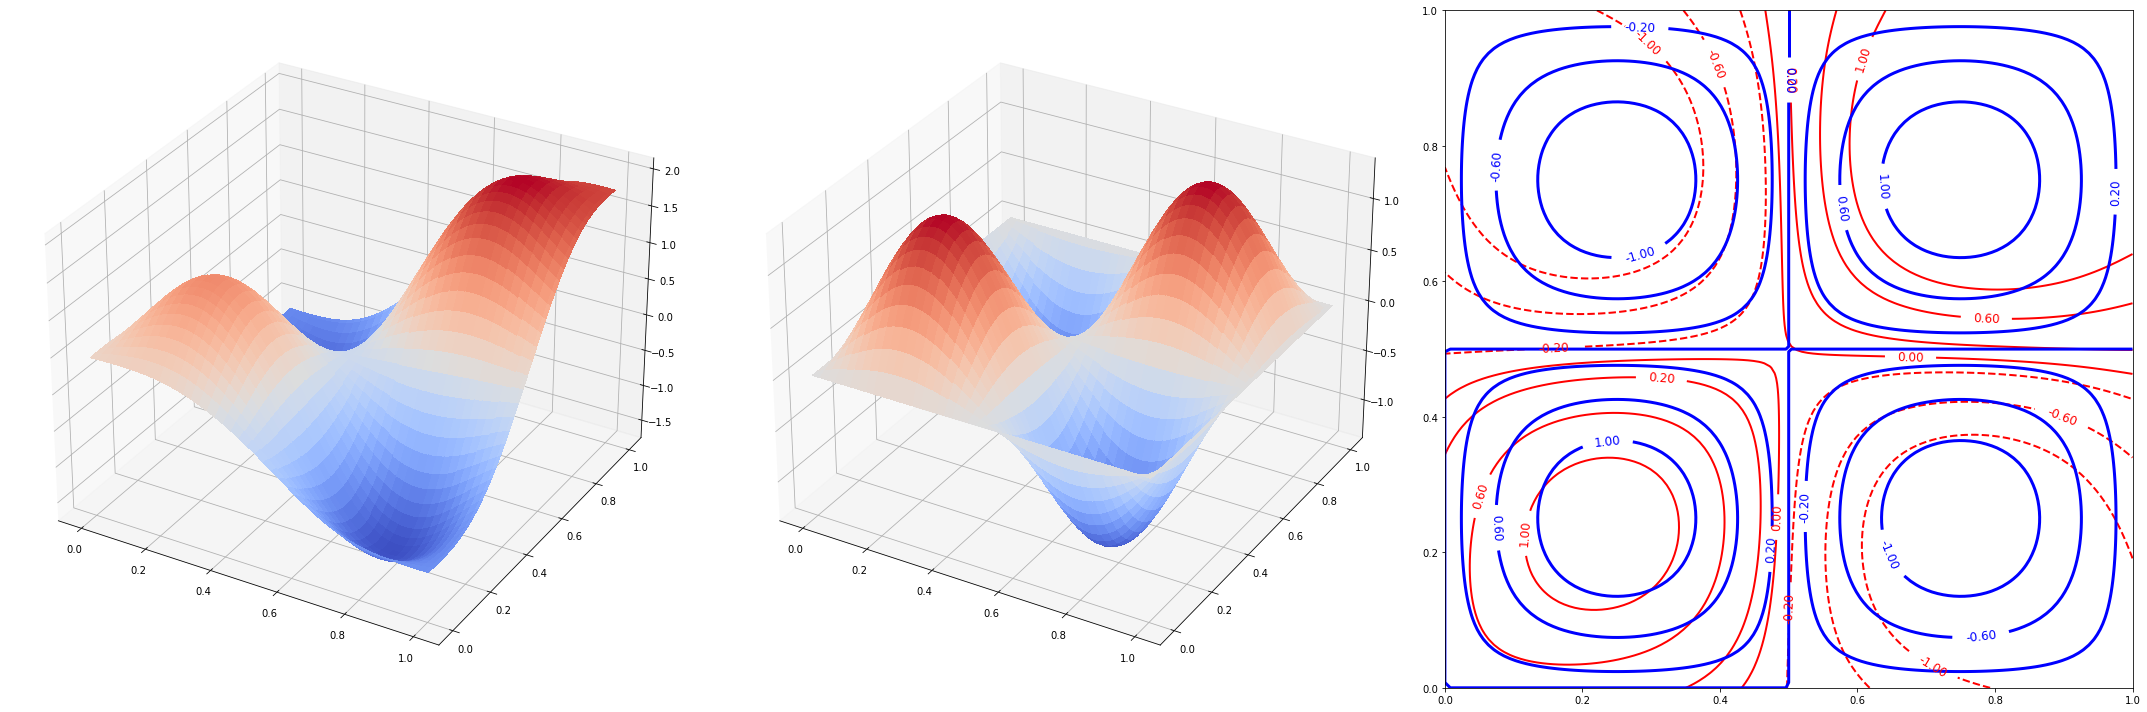

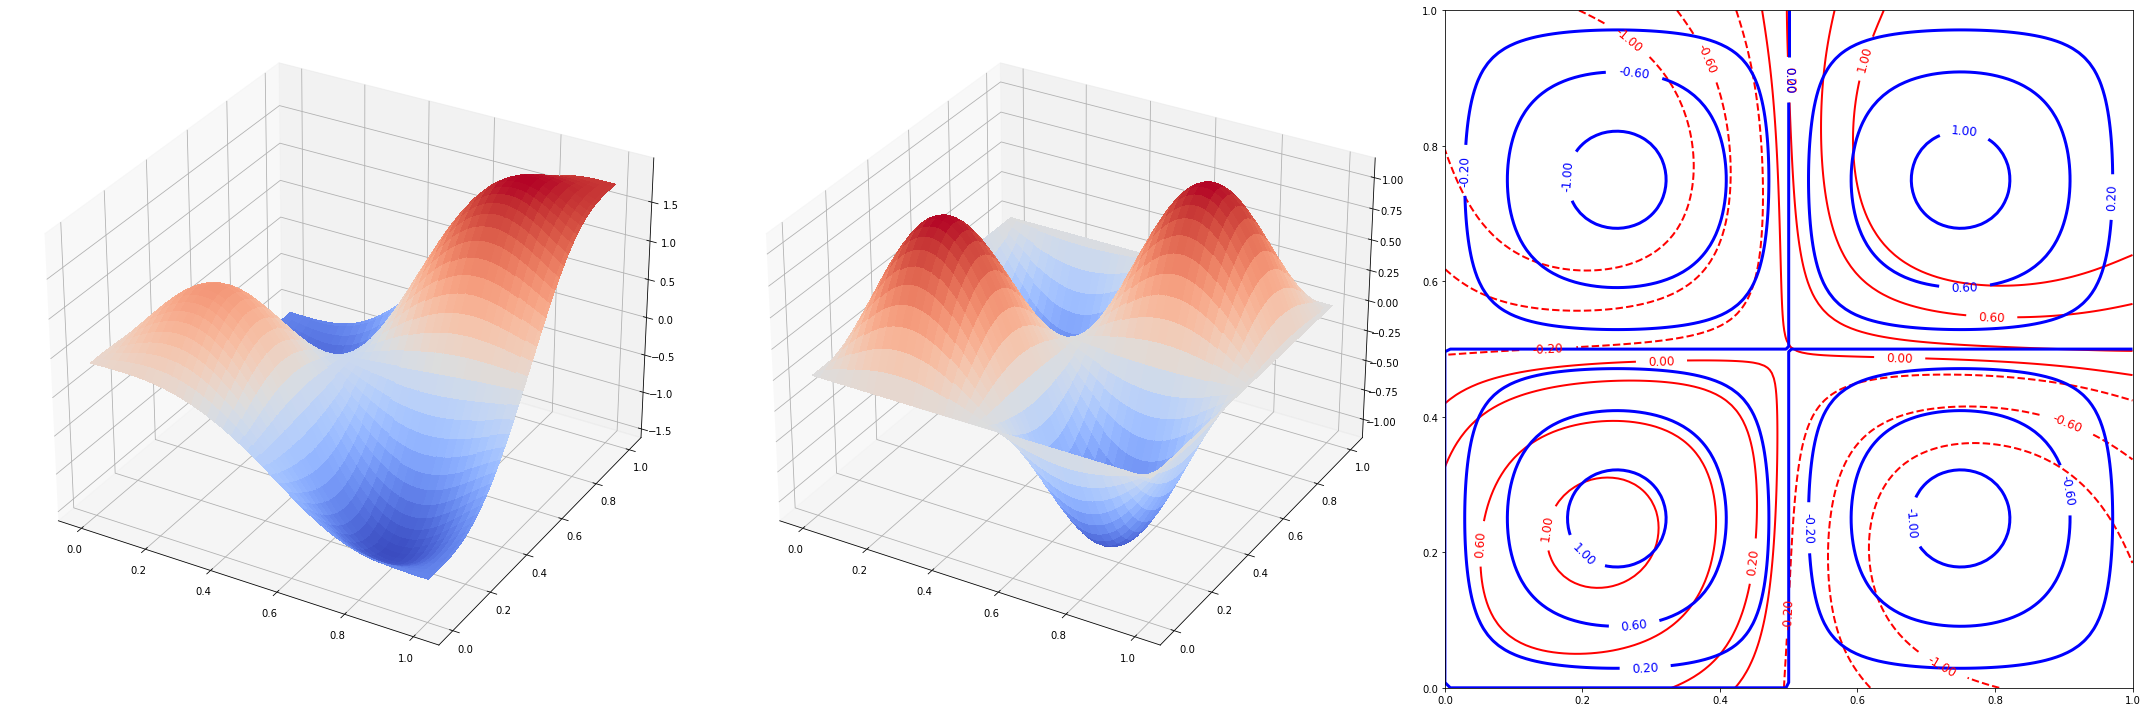

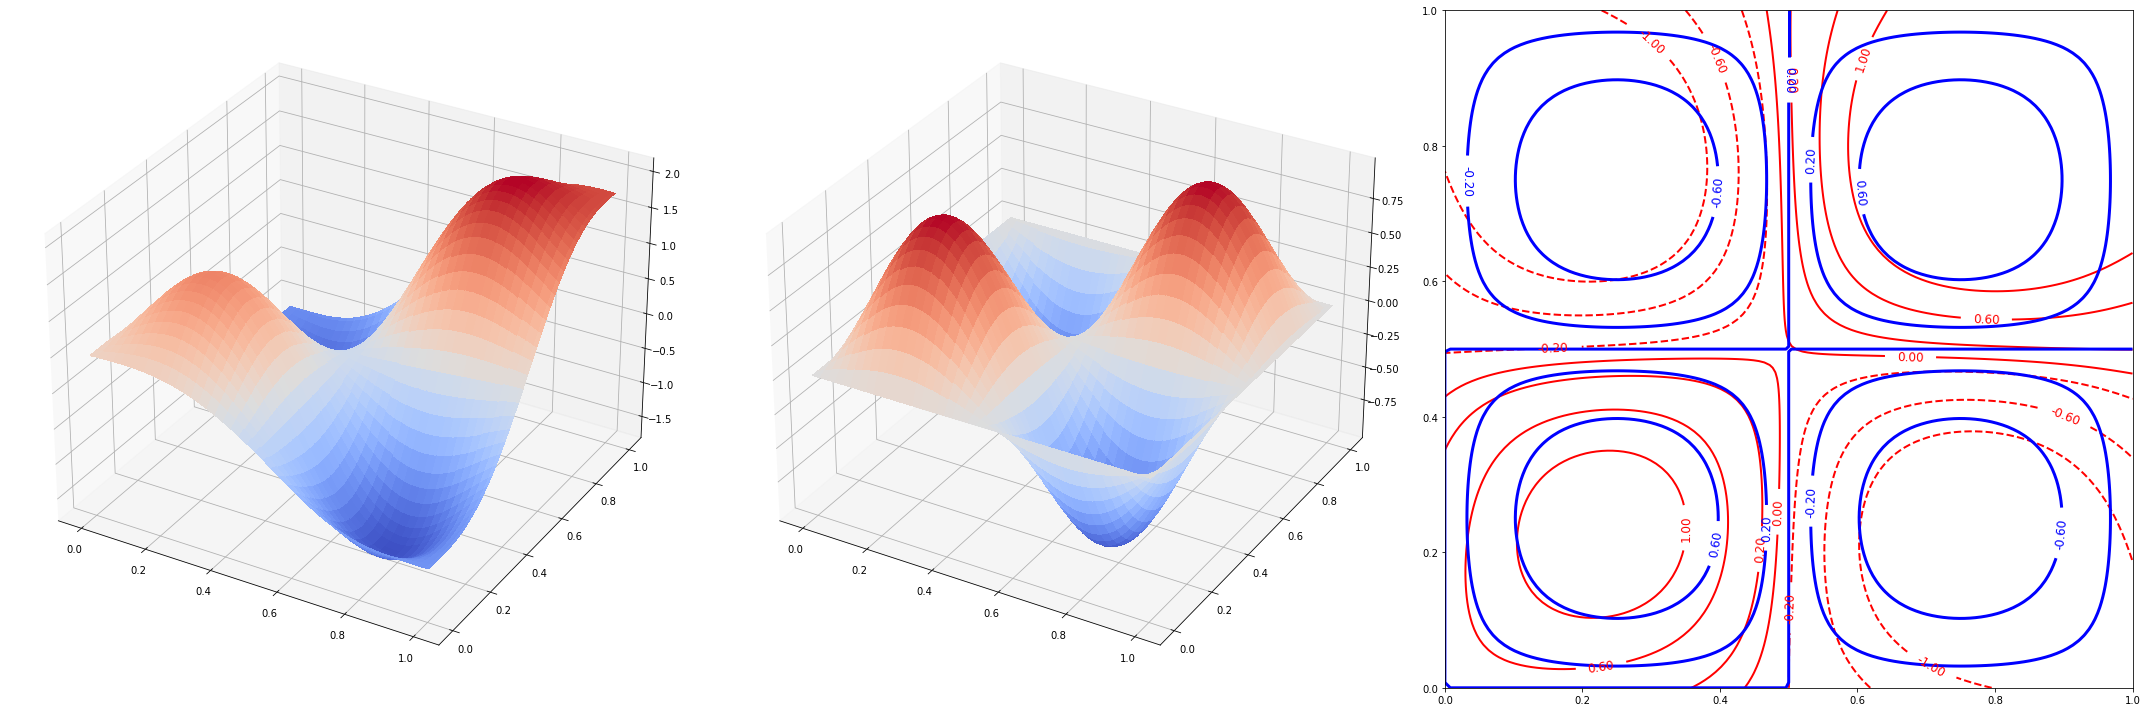

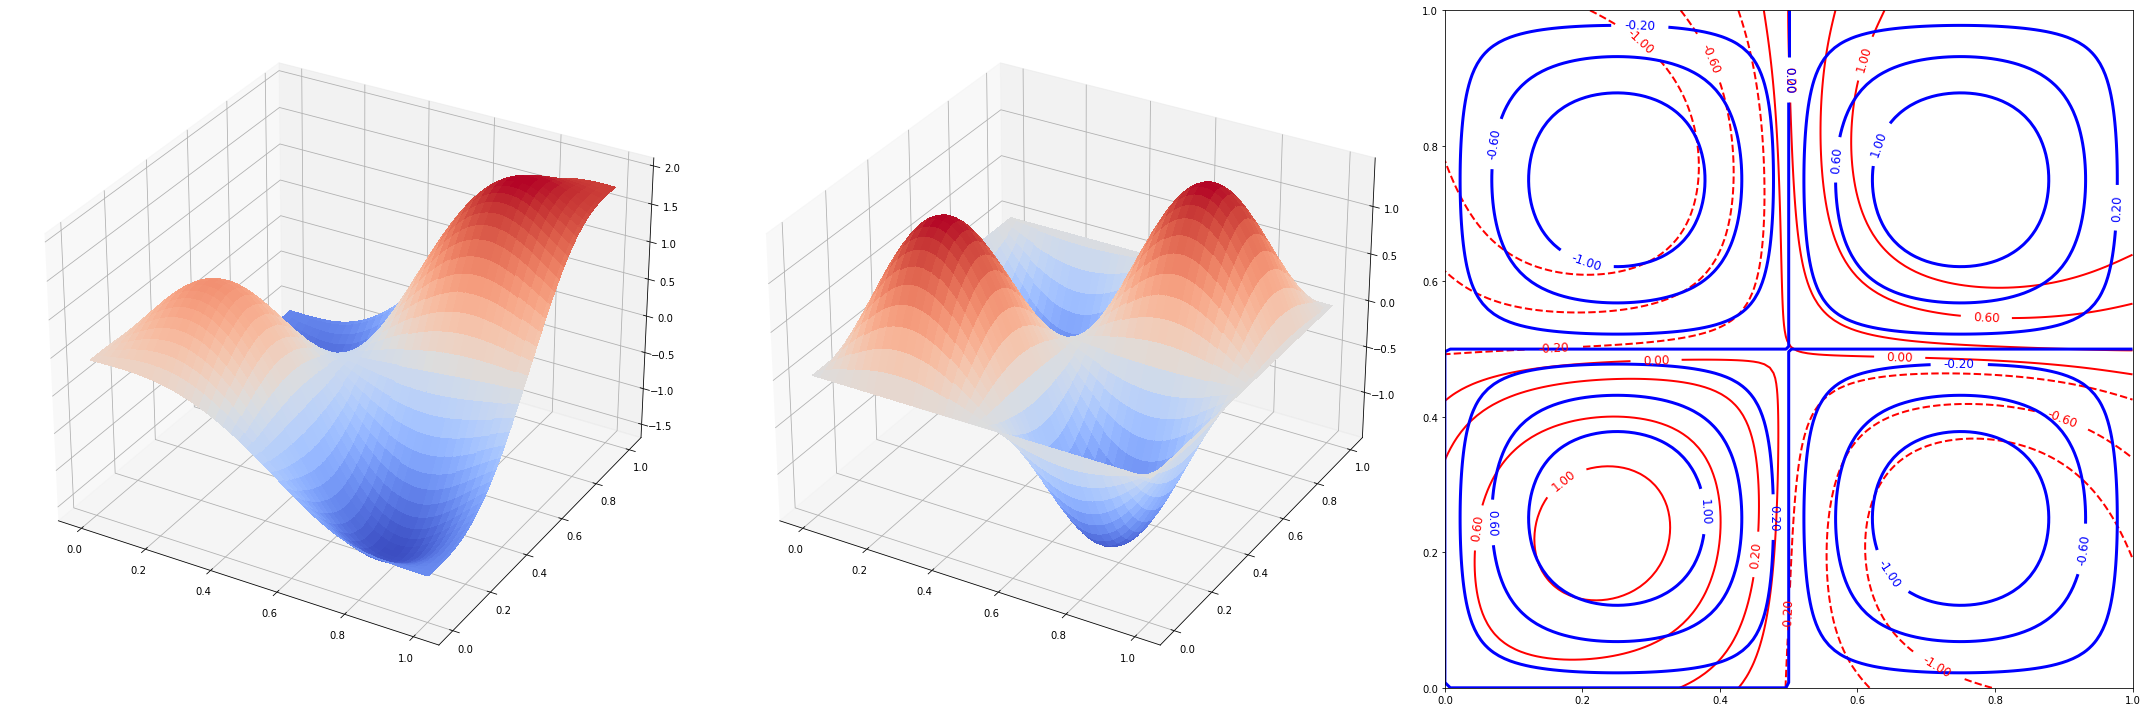

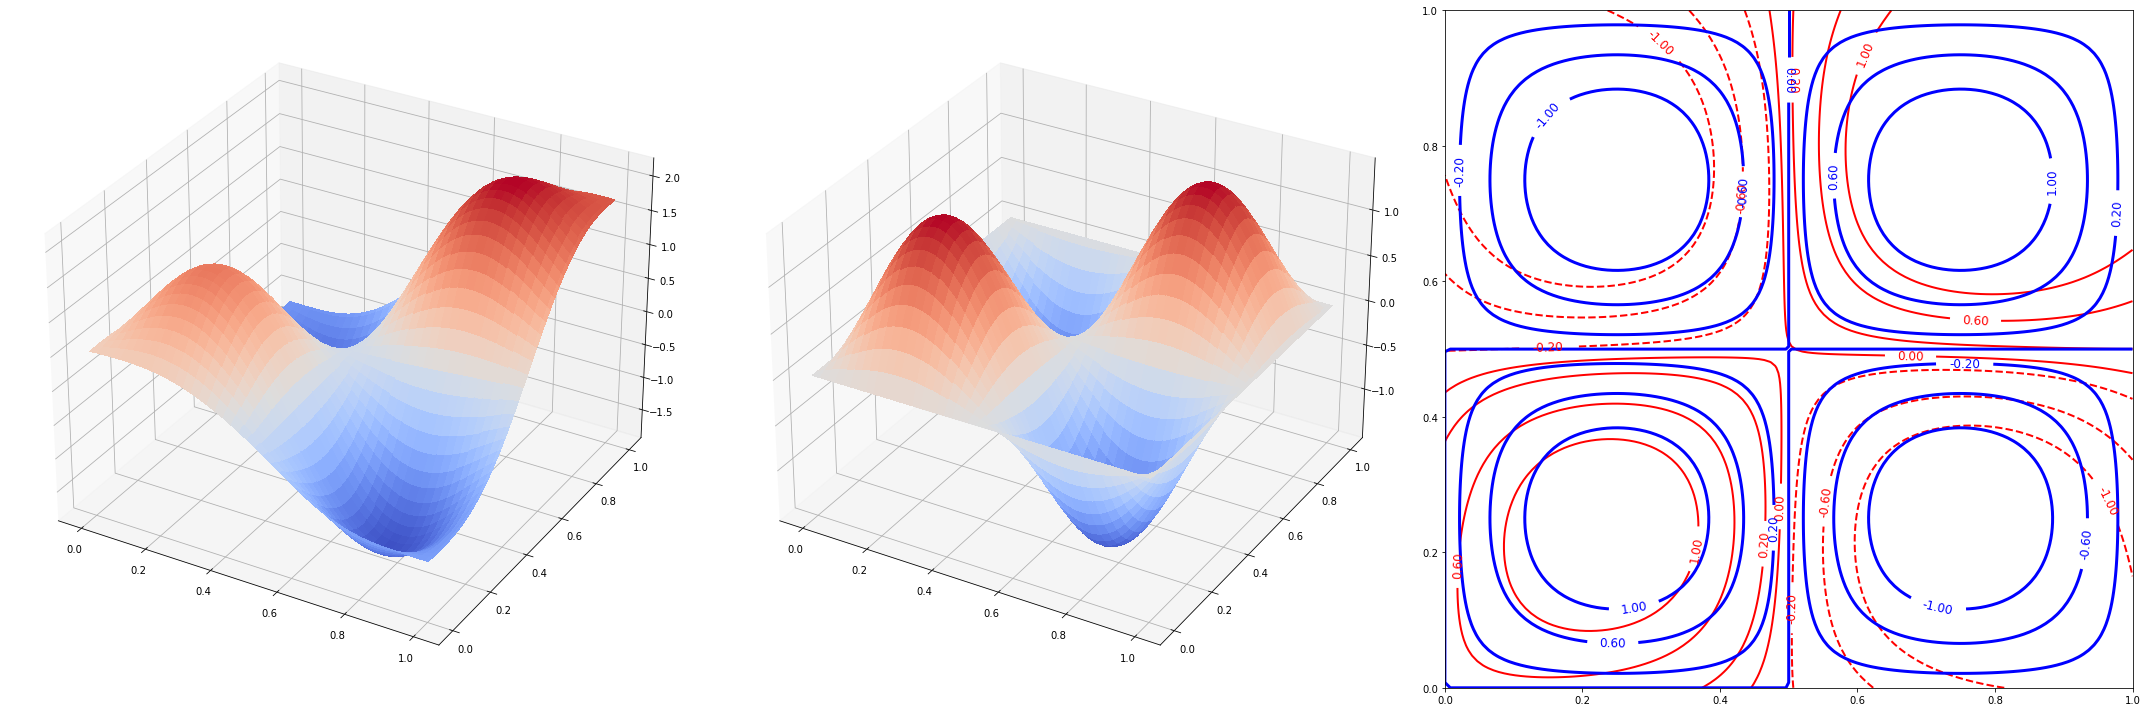

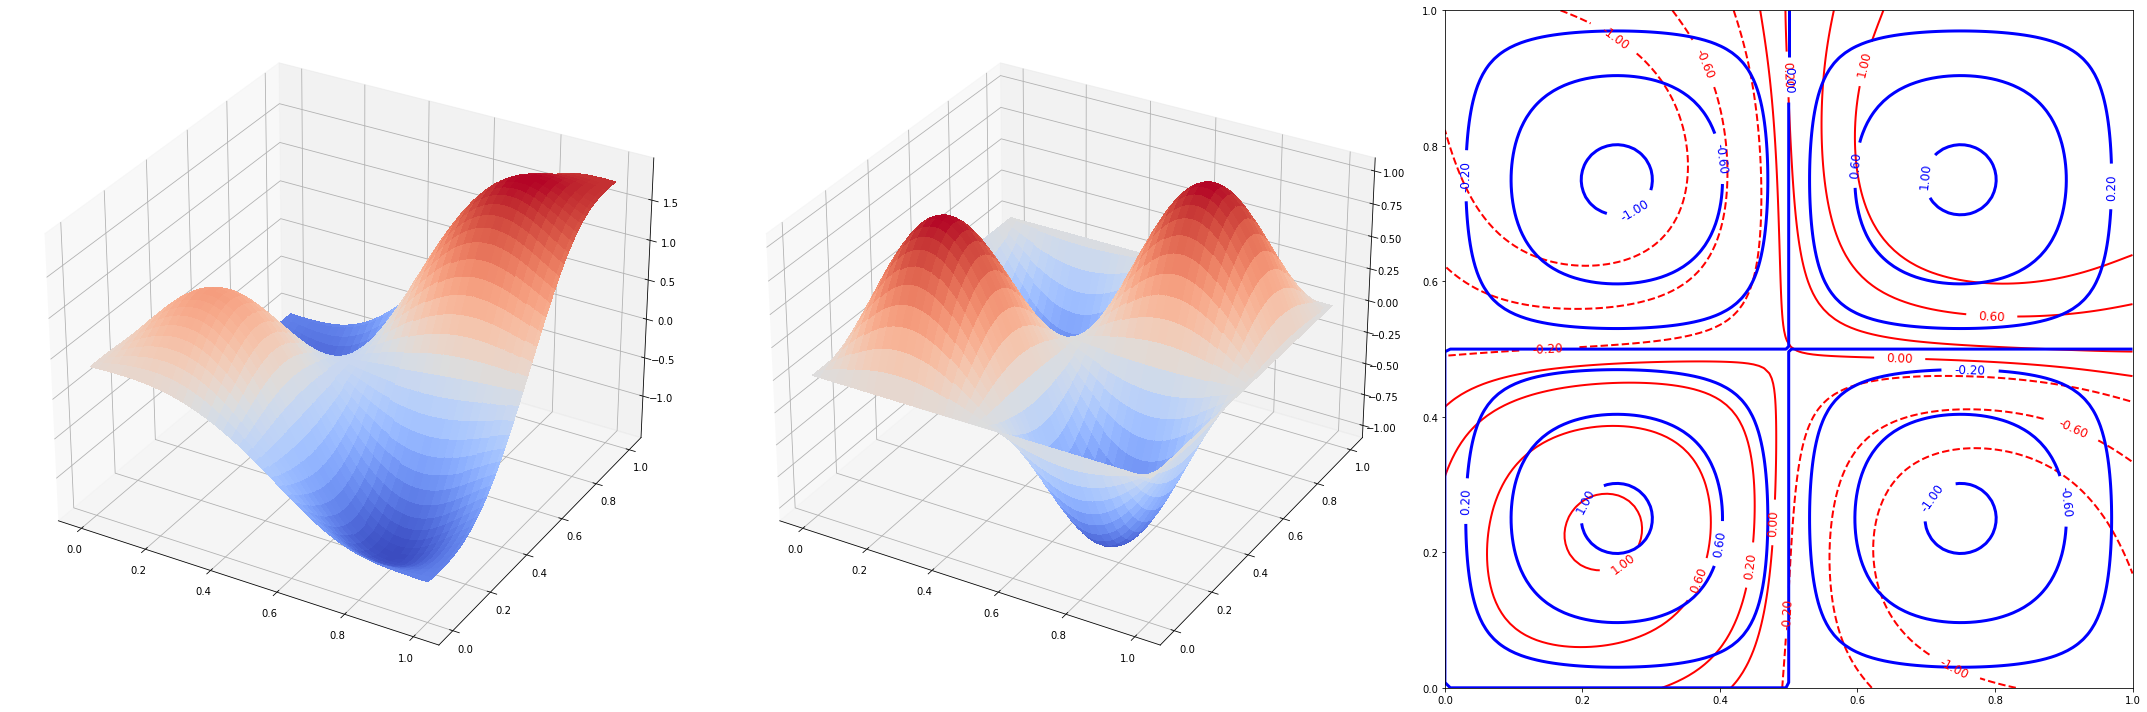

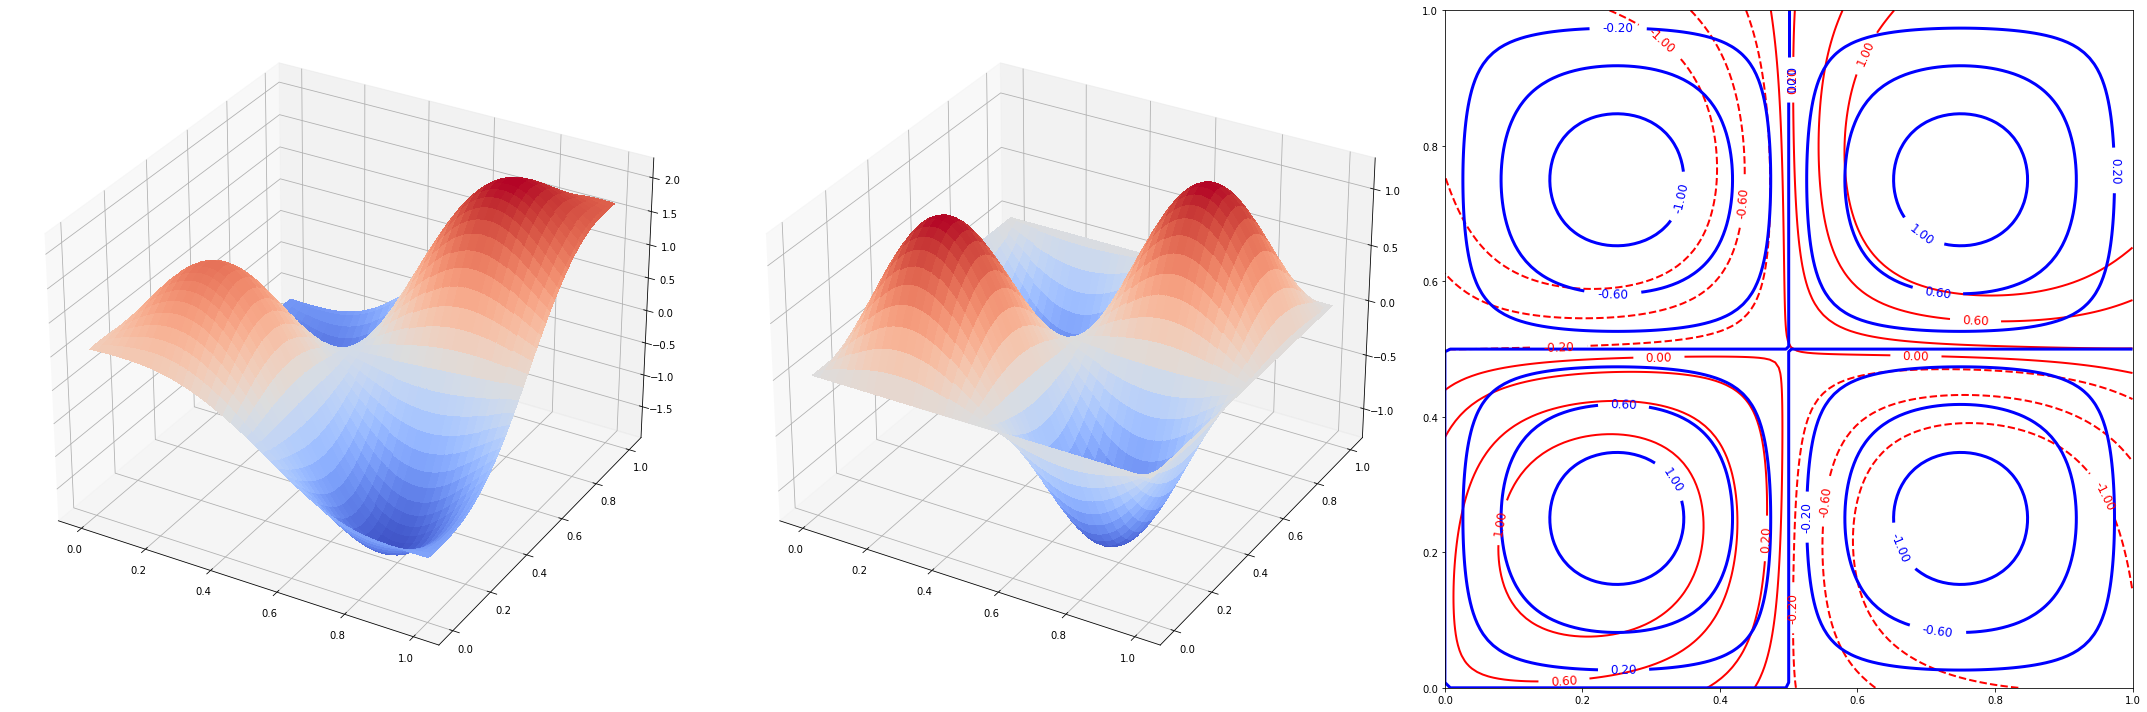

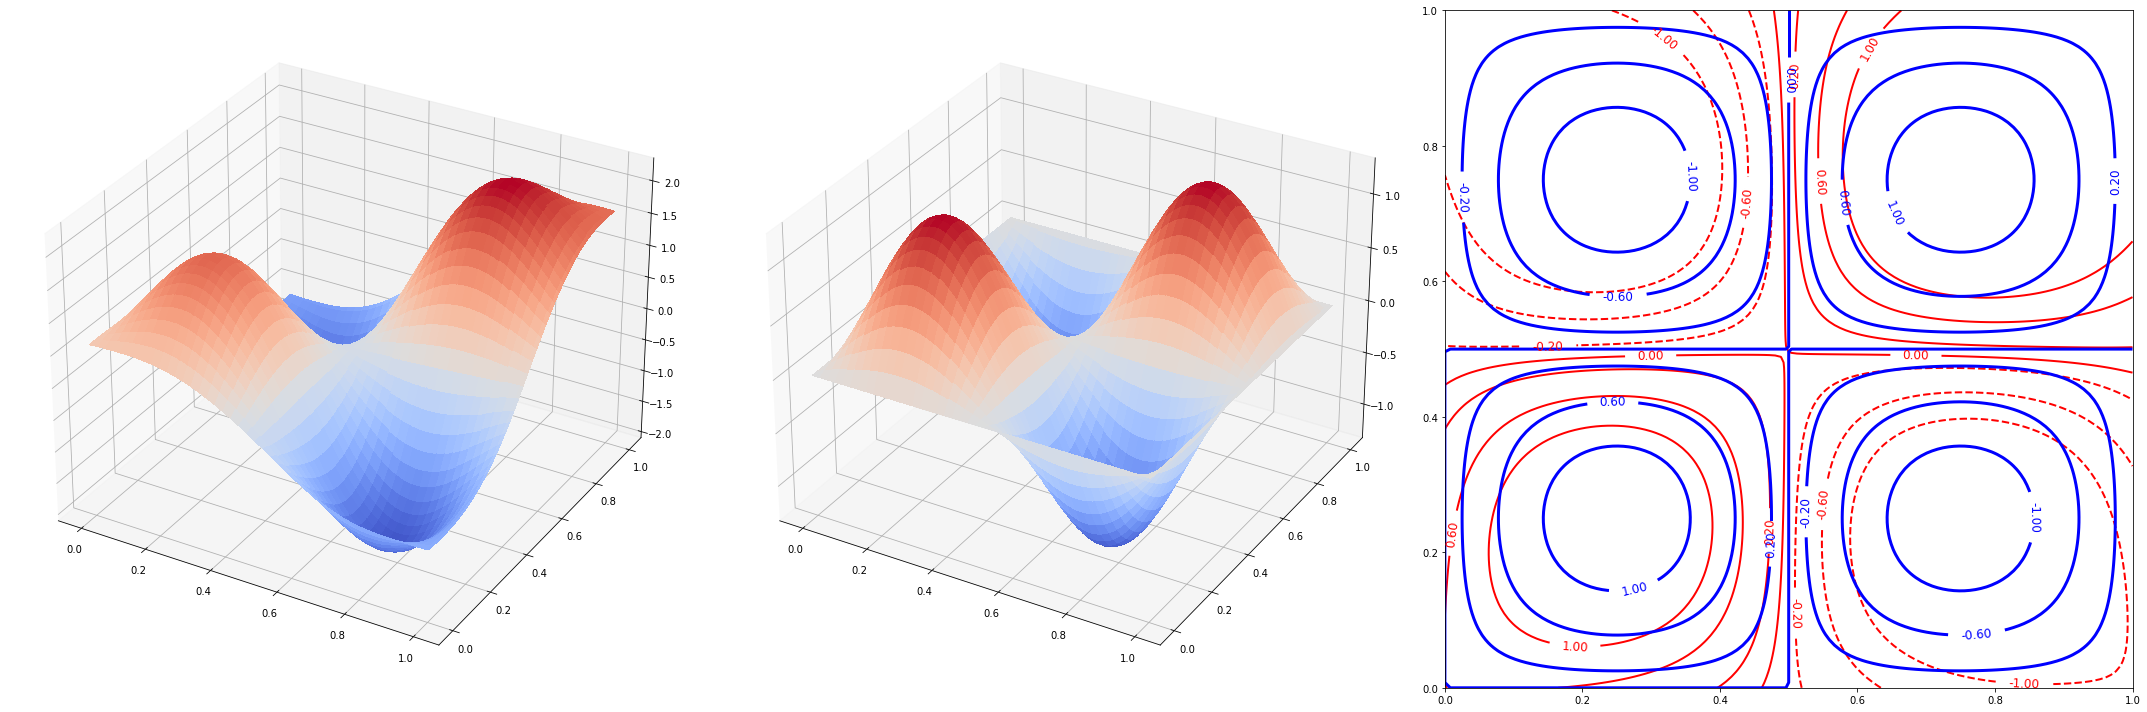

In [58]:
from pl_trainer import LinalgTrainer
import torch.nn.functional as F
from models import UNet
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from pathlib import Path

path = Path('./u/lin1e-2/')
N = 128
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
xx, yy = np.meshgrid(x, y)
U2nd = np.load('./ValU2nd.npy')
for idx, p in enumerate(path.glob('*.npy')):
    pre = np.load(p)
    u = U2nd[idx].reshape(xx.shape)
    
#     print(np.linalg.norm())
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(30)
    
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax3 = fig.add_subplot(1, 3, 3)
    
    levels = [-1, -0.6, -0.2, 0, 0.2, 0.6, 1]
    surf_pre = ax1.plot_surface(xx, yy, pre, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    surf_ans = ax2.plot_surface(xx, yy, u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    cp1 = ax3.contour(xx, yy, pre, colors='r', levels=levels, linewidths=2)
    cp2 = ax3.contour(xx, yy, u, colors='b', levels=levels, linewidths=3, linestyles='solid')
    ax3.clabel(cp1, fmt='%.2f', inline=1, fontsize='large')
    ax3.clabel(cp2, fmt='%.2f', inline=1, fontsize='large')
    fig.tight_layout()

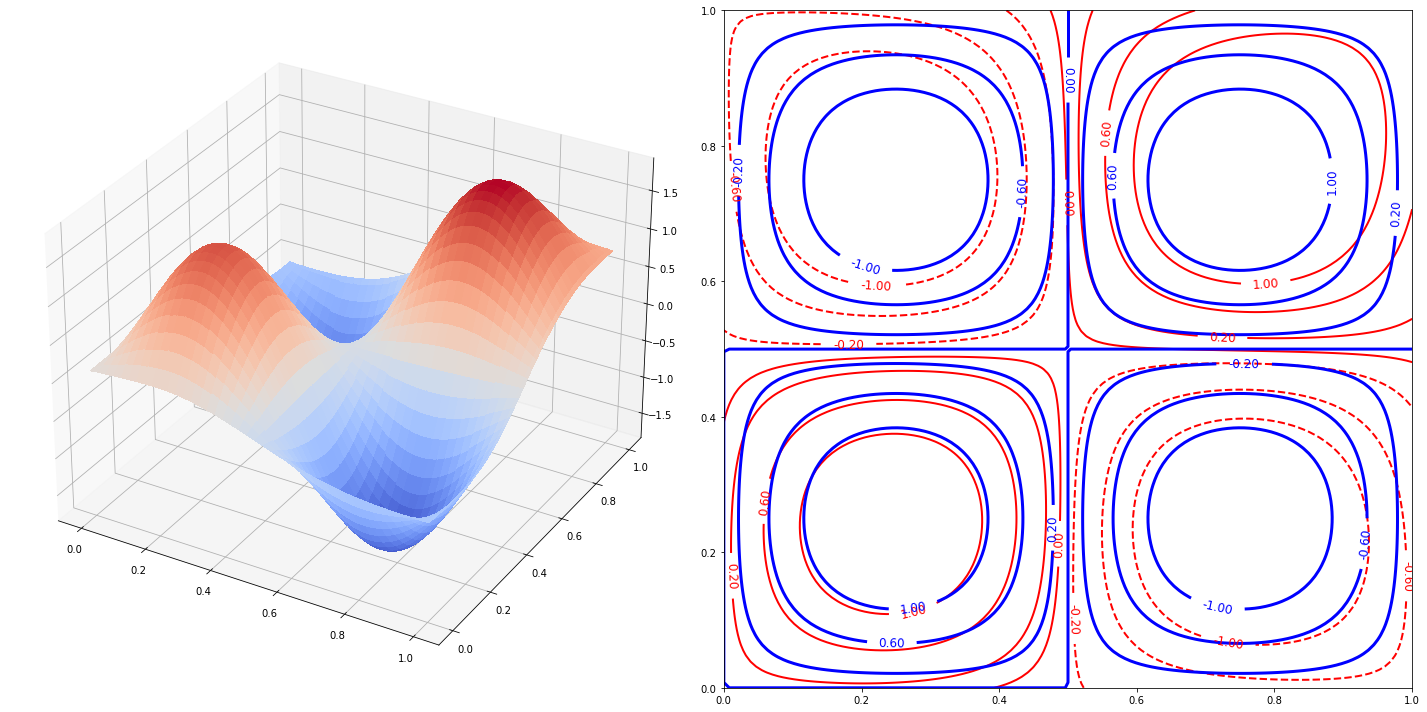

In [57]:
f = lambda x,y: 8*np.pi**2*np.sin(2*np.pi*x)*np.sin(2*np.pi*y) 
u = lambda x,y: np.sin(2*np.pi*x)*np.sin(2*np.pi*y) 

trainer = LinalgTrainer(net = UNet(1, 3, 2),
                              loss = F.mse_loss,
                              val_save_path='./u/lin1e-2/',
                              A = './A2nd.npz',
                              lr=1e-3)
ckpt_path = './lightning_logs/version_2/checkpoints/epoch=48-step=49000.ckpt'
ckpt = torch.load(ckpt_path)
trainer.load_state_dict(ckpt['state_dict'])
trainer.freeze()

Q = 1.5
# h = 0.01
a = 1
N = 128
x = np.linspace(0, a, N)
y = np.linspace(0, a, N)
xx, yy = np.meshgrid(x, y)

ans = Q * u(xx, yy)
force = Q * f(xx, yy)
data = np.concatenate((xx[np.newaxis,...], yy[np.newaxis,...], force[np.newaxis, ...]), axis=0)
data = torch.from_numpy(data)[None, ...]
data = data.to(torch.float32)
pre = trainer(data).squeeze().cpu().numpy()

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)

levels = [-1, -0.6, -0.2, 0, 0.2, 0.6, 1]
surf_pre = ax1.plot_surface(xx, yy, pre, cmap=cm.coolwarm, linewidth=0, antialiased=False)
cp1 = ax2.contour(xx, yy, pre, colors='r', levels=levels, linewidths=2)
cp2 = ax2.contour(xx, yy, ans, colors='b', levels=levels, linewidths=3, linestyles='solid')
ax2.clabel(cp1, fmt='%.2f', inline=1, fontsize='large')
ax2.clabel(cp2, fmt='%.2f', inline=1, fontsize='large')
fig.tight_layout()